In [1]:
from collections import namedtuple

In [2]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.distributions import multivariate_normal

In [3]:
from typing import Tuple, List

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class Transformation(nn.Module):
    
    def __init__(self):
        super(Transformation, self).__init__()
        self.training = None
        self.log_det = None
        
    @property
    def training(self):
        return self._training
    
    @training.setter
    def training(self, enable:bool):
        if not enable:
            self.log_det = None
        self._training = enable
    
    def forward(self, zi):
        if self.training:
            self.log_det = torch.log( self.det( zi ).squeeze() + 1e-7 )
        return self.transform( zi )

planar functions:
$$f(z) = z + u h(w^Tz +b)$$

their derivatives:
$$\psi (z) = h'(w^Tz + b)w$$

determinant:
$$\left | \det\frac{df}{dz}\right | = \left | \det \left (I + u \psi (z)^T \right ) \right | = \left | 1 + u^T \psi(z) \right |$$

flow:
$$\ln_{q_K} (z_K) = \ln_{q_0}(z) - \sum_{k=1}^{K} \ln \ \left | 1 + u_k^T \psi_k(z_{k-1}) \right |$$

In [6]:
class PlanarTransformation(Transformation):
    
    def __init__(self, dim:int, u:list=None, w:list=None, b:list=None, training:bool=True):
        
        super(PlanarTransformation, self).__init__()
        
        self.dim = dim
        self.w = nn.Parameter(torch.Tensor(1, dim))
        self.b = nn.Parameter(torch.Tensor(1))
        self.u = nn.Parameter(torch.Tensor(1, dim))
        self.h = nn.Tanh()
        
        self.reset()
        
        if u is not None:
            self.u.data = torch.Tensor(u).unsqueeze(0)
        if w is not None:
            self.w.data = torch.Tensor(w).unsqueeze(0)
        if b is not None:
            self.b.data = torch.Tensor(b)
    
        if torch.dot(self.w.data.squeeze(), self.u.data.squeeze()) < -1:
            print( "adjusting u")
            dotwu = torch.dot( self.w.data.squeeze(), self.u.data.squeeze() )
            self.u.data = self.u + ( -1 + torch.log( 1 + torch.exp( dotwu ) ) - dotwu ) \
                            * self.w.data / torch.sqrt( torch.dot( self.w.data.squeeze(), self.w.data.squeeze() ) )

        self.training = training
        
    def reset(self):
        self.w.data.uniform_(-0.01, 0.01)
        self.u.data.uniform_(-0.01, 0.01)
        self.b.data.uniform_(-0.01, 0.01)
            
    def transform(self, z):
        return z + self.u * self.h( F.linear(z, self.w, self.b) )
    
    def h_deriv(self, x):
        ff = self.h( x )
        return 1 - ff * ff
    
    def psi(self, z):
        return self.h_deriv( F.linear(z, self.w, self.b) ) * self.w
    
    def det(self, z):
        return (1 + torch.mm( self.psi( z ), self.u.data.t() ) ).abs()

In [7]:
class RadialTransformation(Transformation):
    
    def __init__(self, dim:int, z0=None, alpha=None, beta=None, training:bool=True):
        
        super(RadialTransformation, self).__init__()
        
        self.dim = dim
        self.z0 = nn.Parameter(torch.Tensor(dim))
        self.alpha = nn.Parameter(torch.Tensor(1))
        self.beta = nn.Parameter(torch.Tensor(1))
        
        self.reset()
        
        if z0 is not None:
            self.z0.data = torch.Tensor(z0)
        
        if alpha is not None:
            self.alpha.data = torch.Tensor(alpha)
        
        if beta is not None:
            self.beta.data = torch.Tensor(beta)

        if self.beta < -self.alpha:
            print( "adjusting beta")
            self.beta.data = -self.alpha + torch.log( 1 + torch.exp( self.beta ) )

        self.training = training
        
    def reset(self):
        self.z0.data.uniform_(-0.01, 0.01)
        self.alpha.data.uniform_(0.0, 0.01)
        self.beta.data.uniform_(-0.01, 0.01)
        
    def transform(self, z):
        r = z - self.z0
        r = torch.sqrt( torch.bmm( r.unsqueeze(1), r.unsqueeze(2) ) ).squeeze()
        return z + self.beta * (self.h( r ).expand(2,-1).data.t() * (z - self.z0))
    
    def h(self, r):
        return 1 / (self.alpha + r)
    
    def h_deriv(self, r):
        ff = self.h( r )
        return - ff * ff
    
    def det(self, z):
        r = z - self.z0
        r = torch.sqrt( torch.bmm( r.unsqueeze(1), r.unsqueeze(2) ) ).squeeze()
        tmp = 1 + self.beta * self.h( r )
        return tmp * (tmp + self.beta * self.h_deriv(r) * r)

In [8]:
class NormalizingFlow(nn.Module):
    
    def __init__( self, transformation, dim:int, K:int, transformations=None ):
        super(NormalizingFlow, self).__init__()
        self.K = K
        self.dim = dim
        self.transformation = transformation
        
        if transformations is None:
            transformations = [ self.transformation( dim ) for i in range( K ) ]
        self.flow = nn.Sequential(*transformations)
        
    def get_log_qk(self):
        return self.flow[-1].log_det
    
    def get_sum_log_qk(self):
        ret = 0
        for trans in self.flow:
            ret += trans.log_det
        return ret
        
    def forward( self, z ):
        return self.flow(z)

In [9]:
def target_density(z):

    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)

    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2 + 1e-7)

    return torch.exp(-u)

standard_normal_2d = multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))

class LossFunction(nn.Module):

    def __init__(self, target_density, log_q0):
        super().__init__()
        self.log_q0 = log_q0
        self.target_density = target_density

    def forward(self, z0, zk, sum_log_jacobians):
        return (self.log_q0(z0) - sum_log_jacobians - torch.log(self.target_density(zk) + 1e-7)).mean()

In [10]:
def train_flow( flow, log_q0, target_density,
    initial_lr = 0.01,
    lr_decay = 0.999,
    log_interval = 1000,
    iterations = 10000,
    batch_size = 100, ):
    
    lf = LossFunction(target_density=target_density, log_q0=log_q0)
    optimizer = optim.RMSprop(flow.parameters(), lr=initial_lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)



    for iteration in range(1, iterations + 1):

        scheduler.step()

        samples = Variable(standard_normal_2d.sample(torch.Size([batch_size])))
        z0 = samples.clone()
        zk = flow(samples)

        optimizer.zero_grad()
        loss = lf(z0, zk, flow.get_sum_log_qk())
        loss.backward()
        optimizer.step()

        if iteration % log_interval == 1:
            print("Loss on iteration {}: {}".format(iteration , loss.data[0]))

In [11]:
flow = NormalizingFlow( 2, 4, PlanarTransformation, transformations=[PlanarTransformation(2, w=[5.0, 5.0], b=[1e-10], u=[0.1,0.1]),
                                                    PlanarTransformation(2, w=[10.0, 0.0], b=[1e-10], u=[0.1,0.1] ) ] )

In [12]:
flow = NormalizingFlow( 2, 4, PlanarTransformation, transformations=[PlanarTransformation(2, w=[0.0, 5.0], b=[1e-10], u=[-0.1,-0.1]),
                                                    PlanarTransformation(2, w=[5.0, 0.0], b=[1e-10], u=[0.3,0.3])] )

In [13]:
flow = NormalizingFlow( PlanarTransformation, dim=2, K=4 )

In [14]:
train_flow( flow, lambda x: torch.zeros(x.shape[0]), target_density, iterations=10000, batch_size=100 )

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loss on iteration 1: 14.849019050598145
Loss on iteration 1001: 1.4641304016113281
Loss on iteration 2001: 1.9965722560882568
Loss on iteration 3001: 2.1180243492126465
Loss on iteration 4001: 1.9147778749465942
Loss on iteration 5001: 1.90888512134552
Loss on iteration 6001: 1.9715322256088257
Loss on iteration 7001: 2.008640766143799
Loss on iteration 8001: 1.949527382850647
Loss on iteration 9001: 1.6213197708129883


In [15]:
x, y = np.meshgrid(np.linspace(-7,7,100), np.linspace(-7,7,100))
z0 = torch.tensor(np.dstack((x,y)).reshape(-1, 2), dtype=torch.float32)
zk = flow( z0 ).data.numpy()
qk = flow.get_log_qk().data.numpy()

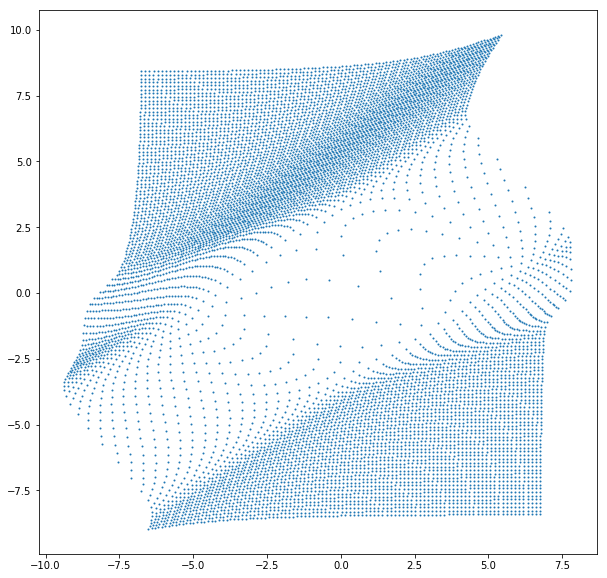

In [16]:
plt.figure(figsize=[10,10])
plt.scatter( zk[:,0], zk[:,1], 1)
plt.show()

The inference algorithm:
    
Parameters: $\phi$ variational, $\theta$ generative
    
while not converged do:
        
$\quad \text{x = {Get mini batch}}\\
\quad z_0 ~ q_0(\cdot | x)\\
\quad z_K = f_K( ... f_1(z_0) )\\
\quad F(x) \approx F(x, z_K)\\
\quad \Delta \theta \propto - \nabla_\theta F(x)\\
\quad \Delta \phi \propto - \nabla_\phi F(x)$